# Introduction

This notebook was created by Rohit Satija (rsatija@berkeley.edu) and is part of a series of classification algorithms used in the steaming-hot project for the May 2021 Erdős Institute Data Science BootCamp

# Data 

In [1]:
#For data manipulation
import pandas as pd
import numpy as np

#For plotting
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

In [2]:
data = pd.read_csv('AllData.csv')  # This csv file contains cleaned data of ~10,000 games inlcuding various features
                                   # and mean_player count in the column 'mean'
data = data[data['mean']>1]        # We discard games with mean_player<1 as these represent suspicious games that
                                   # not even the game developer plays
data.shape

(8093, 81)

In [3]:
#Drop columns that are not needed for classification, e.g. Name, App_id, etc
proc_data = data.drop(['App_id','Name','ReleaseDate','Metacritic','SteamSpyOwners', 'SteamSpyOwnersVariance',
                      'SteamSpyPlayersEstimate', 'SteamSpyPlayersVariance', 'PriceCurrency','SupportEmail', 
                      'SupportURL', 'AboutText','Background', 'ShortDescrip', 'DetailedDescrip', 'DRMNotice',
                      'ExtUserAcctNotice', 'HeaderImage', 'LegalNotice', 'Reviews','RecommendationCount',
                      'SupportedLanguages', 'Website', 'PCMinReqsText', 'PCRecReqsText',
                      'LinuxMinReqsText', 'LinuxRecReqsText', 'MacMinReqsText','MacRecReqsText',
                      'SteamSpyOwnersNew', 'peak_max', 'peak_mean', 'max'],axis=1)

In [4]:
#This code creates a column called "grade" that one-hot encodes the mean_player count based on popularity
def create_grades(count):
#Return 1 if avg_players>100 and 0 if avg_players<5
        if 100<=count:   
            return 1
        elif count<5:
            return 0
#Return -1 if 5<avg_players<100 in the middle category
        else:
            return -1

proc_data['grade']=proc_data['mean'].apply(create_grades)

#Drop games in the middle category
data_for_classification=proc_data[(proc_data['grade']==0)|(proc_data['grade']==1)]

In [5]:
#Design matrix containing all features
X=data_for_classification.drop(['mean','grade'],axis=1).copy()
X=X.astype(float)

#Target variable: Popularity Grade
y=data_for_classification['grade'].copy()

# Model

In [6]:
#For modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.base import clone

#For performance measurement
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

#To prevent ugly warnings
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

In [7]:
#Create a train-test split of the design matrix and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y,                
                                                    test_size=0.25,    #75-25 split
                                                    random_state = 42, #Random seed for reproducibility
                                                    shuffle=True,      #Shuffle the data before split
                                                    stratify=y)        #Stratify on the target variable to prevent
                                                                       #class imbalance

In [8]:
#The following code runs a 5-fold stratified cross-validation to optimize the hyperparameter n_estimators
#in the AdaBoostClassifier routine

#Create a kfold object
kfold = StratifiedKFold(5,shuffle = True,random_state = 42)

#Define the maximum depth to search for
n = 100

#Create arrays for accuracy_score, precision_score, recall_score, and f1_score
accs = np.zeros((5,n))
prec = np.zeros((5,n))
recs = np.zeros((5,n))
f1s = np.zeros((5,n))

for j in range(1,n+1):
    #Print n_estimators every 10 iterations
    if j%10==0:
        print(j)
    # n_estimators controls how many weak learners we use
    # learning_rate is a hyperparameter that controls how
    # aggressively we correct incorrect labels
    # algorithm is the algorithm that sklearn runs to fit the model
    # SAMME.R or SAMME are the options, SAMME.R allows calculation
    # of probabilities.
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                n_estimators = j,
                algorithm="SAMME.R",
                learning_rate = 0.5
            )
    
    i = 0
    for train_index,test_index in kfold.split(X_train,y_train):
        
        # Get the cv train test split
        X_train_train,X_train_test = X_train.iloc[train_index],X_train.iloc[test_index]
        y_train_train,y_train_test = y_train.iloc[train_index],y_train.iloc[test_index]
        
        #Fit the model
        ada_clf_clone = clone(ada_clf)
        ada_clf_clone.fit(X_train_train,y_train_train)
        
        #Predict   
        y_predict = ada_clf_clone.predict(X_train_test)
        
        #Measure accuracy, precision, recall, f1   
        accs[i,j-1] = accuracy_score(y_train_test,y_predict)
        prec[i,j-1] = precision_score(y_train_test,y_predict)
        recs[i,j-1] = recall_score(y_train_test,y_predict)
        f1s[i,j-1] = f1_score(y_train_test,y_predict)

        i = i + 1

10
20
30
40
50
60
70
80
90
100


# Result

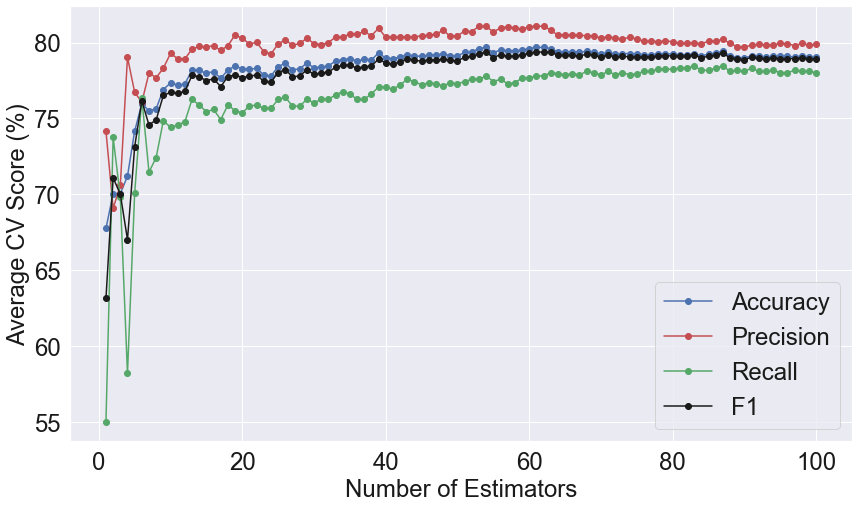

In [9]:
#Plot the result
plt.figure(figsize=(14,8))
fontsize=24
fontcolor='k'

plt.plot(range(1,n+1), 100*np.mean(accs,axis=0),'b-o', label="Accuracy")
plt.plot(range(1,n+1), 100*np.mean(prec,axis=0),'r-o', label="Precision")
plt.plot(range(1,n+1), 100*np.mean(recs,axis=0),'g-o', label="Recall")
plt.plot(range(1,n+1), 100*np.mean(f1s,axis=0),'k-o', label="F1")

plt.xlabel("Number of Estimators", fontsize=fontsize,color=fontcolor)
plt.ylabel("Average CV Score (%)", fontsize=fontsize,color=fontcolor)

plt.setp(plt.legend(fontsize=fontsize).get_texts(), color=fontcolor)
plt.xticks(fontsize=fontsize,color=fontcolor)
plt.yticks(fontsize=fontsize,color=fontcolor)
plt.show()

In [10]:
# Best accuracy:
ada_best_acc,ada_best_acc_index=(np.max(100*np.mean(accs, axis=0)),np.argmax(100*np.mean(accs, axis=0)))
print('max accuracy:',np.round(ada_best_acc,2),'n_estimators:',ada_best_acc_index+1)
print()

# Best Precision:
ada_best_prec,ada_best_prec_index=(np.max(100*np.mean(prec, axis=0)),np.argmax(100*np.mean(prec, axis=0)))
print('max precision:',np.round(ada_best_prec,2),'n_estimators:',ada_best_prec_index+1)
print()

# Best Recall:
ada_best_rec,ada_best_rec_index=(np.max(100*np.mean(recs, axis=0)),np.argmax(100*np.mean(recs, axis=0)))
print('max recall:',np.round(ada_best_rec,2),'n_estimators:',ada_best_rec_index+1)
print()

# Best F1-score:
ada_best_f1,ada_best_f1_index=(np.max(100*np.mean(f1s, axis=0)),np.argmax(100*np.mean(f1s, axis=0)))
print('max f1-score:',np.round(ada_best_f1,2),'n_estimators:',ada_best_f1_index+1)
print()

max accuracy: 79.68 n_estimators: 61

max precision: 81.08 n_estimators: 53

max recall: 78.47 n_estimators: 87

max f1-score: 79.38 n_estimators: 62



We find that n_estimators = 62 performs well for all metrics

In [11]:
#Let us now train our validated model with n_estimators=62 on the full training set and calculate performance on 
#test set
ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                n_estimators = ada_best_f1_index+1,
                algorithm="SAMME.R",
                learning_rate = 0.5
            )

ada.fit(X_train,y_train)

y_pred = ada.predict(X_test)

print('test accuracy:',np.round(100*accuracy_score(y_test,y_pred),2))
print('test precision:',np.round(100*precision_score(y_test,y_pred),2))
print('test recall:',np.round(100*recall_score(y_test,y_pred),2))
print('test f1-score:',np.round(100*f1_score(y_test,y_pred),2))

test accuracy: 79.22
test precision: 80.23
test recall: 77.92
test f1-score: 79.06


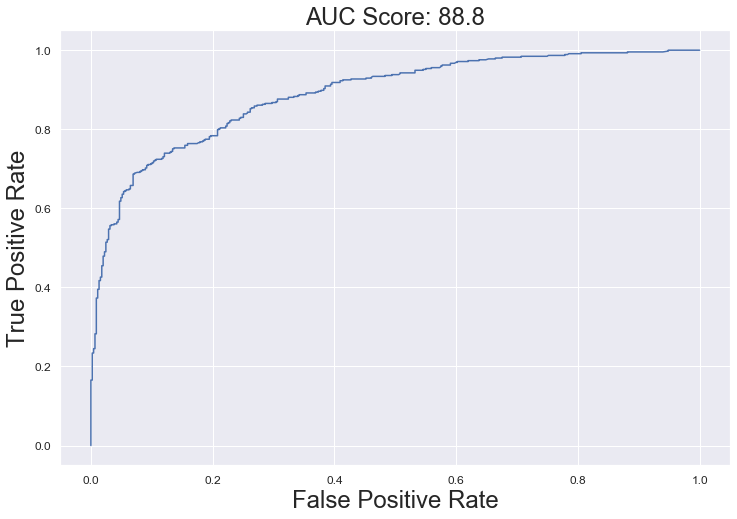

In [12]:
#Plot the ROC curve and calculate the final AUC score on the test set
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

probs = ada.predict_proba(X_test)

fpr,tpr,cutoffs = roc_curve(y_test,probs[:,1])

plt.figure(figsize=(12,8))

plt.plot(fpr,tpr)

plt.title("AUC Score: "+str(np.round(100*roc_auc_score(y_test,probs[:,1]),2)),fontsize=fontsize)
plt.xlabel("False Positive Rate",fontsize=fontsize)
plt.ylabel("True Positive Rate",fontsize=fontsize)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

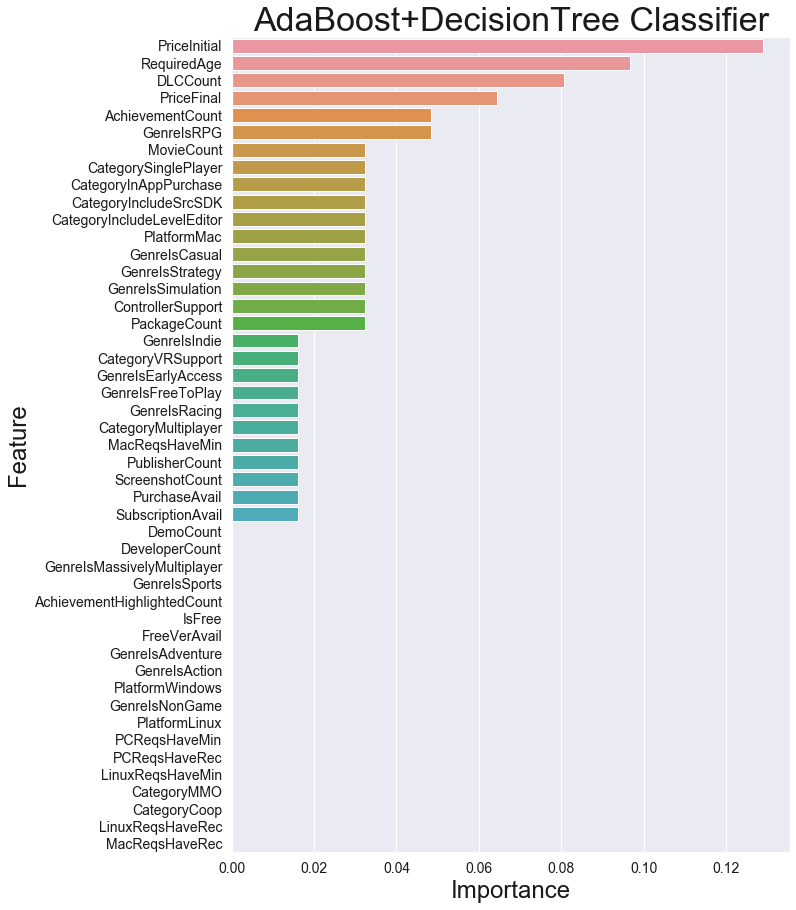

In [13]:
#In this case, we can also access feature importance directly
names = []
scores = []
for name, score in zip(X_test.columns,ada.feature_importances_):
    names.append(name)
    scores.append(np.round(score,4))
    
score_df = pd.DataFrame({'feature':names,'importance':scores})

f,ax = plt.subplots(figsize=(10,15))

plt.title('AdaBoost+DecisionTree Classifier',fontsize=fontsize+10,color=fontcolor)
sns.barplot(x="importance", y="feature", data=score_df.sort_values('importance',ascending=False))

plt.xlabel("Importance",fontsize=fontsize,color=fontcolor)
plt.ylabel("Feature",fontsize=fontsize,color=fontcolor)

plt.xticks(fontsize=fontsize-10,color=fontcolor)
plt.yticks(fontsize=fontsize-10,color=fontcolor)
plt.show()

__That's all folks!__